## MedSAM Point prompt on pancreas data

In [1]:
%matplotlib widget
import nibabel as nib
from segment_anything import sam_model_registry
from os.path import join, isfile, basename
from os import getcwd
from matplotlib import pyplot as plt
from ipywidgets import interact, widgets
from torch.nn import functional as F
import cv2
import torch
import numpy as np
import gc
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt
from skimage import io, transform
from utils.demo import BboxPromptDemo, PointPromptDemo, BboxPromptDemo_nii

In [2]:
image_path= "D:/Stage/Pancreas_dataset/t1/imagesTr/NYU_0162_0000.nii/NYU_0162_0000.nii"
modality='MRI'
nii_data = nib.load(image_path).get_fdata()

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
class PointPromptDemo_nii:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None
        self.image_path = None
        self.slice = None
        self.image = None
        self.image_tensor = None
        

    def show_mask(self, mask, ax, random_color=False, alpha=0.95):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @torch.no_grad()
    def infer(self, x, y):
        coords_1024 = np.array([[[
            x * 1024 / self.img_size[1],
            y * 1024 / self.img_size[0]
        ]]])
        coords_torch = torch.tensor(coords_1024, dtype=torch.float32).to(self.model.device)
        labels_torch = torch.tensor([[1]], dtype=torch.long).to(self.model.device)
        point_prompt = (coords_torch, labels_torch)
        print(point_prompt.shape)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points = point_prompt,
            boxes = None,
            masks = None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )

        low_res_probs = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_probs,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()

        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, image_path, slice, fig_size=5, alpha=0.95, scatter_size=10):

        assert self.image is not None, "Please set image first."
        seg = None
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        plt.tight_layout()

        ax.imshow(self.image)
        ax.axis('off')

        self.image_path = image_path
        self.slice = slice

        def onclick(event):
            if event.inaxes == ax:
                x, y = float(event.xdata), float(event.ydata)
                with torch.no_grad():
                    ## rescale x, y from canvas size to 1024 x 1024
                    seg = self.infer(x, y)

                ax.clear()
                ax.imshow(self.image)
                ax.axis('off')
                ax.scatter(x, y, c='r', s=scatter_size)
                self.show_mask(seg, ax, random_color=False, alpha=alpha)

                gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            out_path = f"{self.image_path.split('.')[0]}_slice_{self.slice}_seg_result.png"
            out_path_segs = f"{self.image_path.split('.')[0]}_slice_{self.slice}segs.png"
            plt.savefig(out_path, bbox_inches='tight', pad_inches=0)
            if seg is not None:
                cv2.imwrite(out_path_segs, seg)
                print(f"Segmentation result saved to {out_path}")

        display(save_button)
        save_button.on_click(__on_save_button_clicked)

    def set_image(self, image, image_tensor):
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        self.image = image
        self.image_tensor = image_tensor
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_tensor)
        
    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor
    

In [9]:
medsam_ckpt_path = "D:\Stage\MedSAM\medsam_point_prompt_flare22.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=medsam_ckpt_path)
medsam_model = medsam_model.to(device)
medsam_model.eval()
point_prompt_demo = PointPromptDemo_nii(medsam_model)

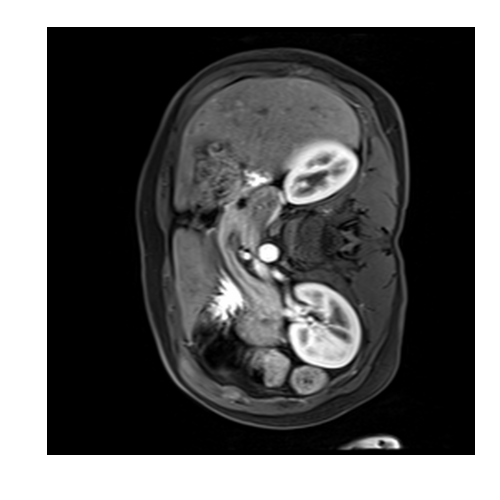

Button(description='save', style=ButtonStyle())

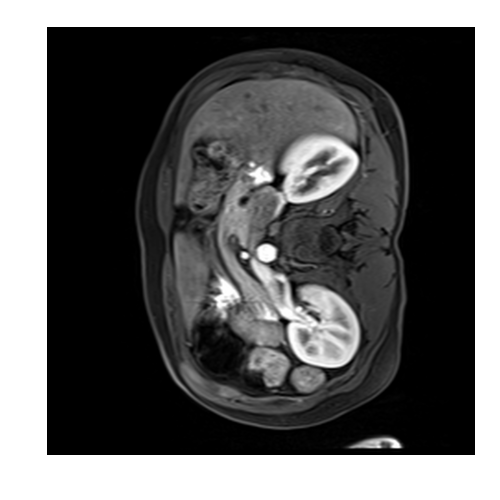

Button(description='save', style=ButtonStyle())

In [21]:
#%%Loop over slices
for slice in range(35,37):
    image_data = nii_data[:,:,slice]

    #%%Normalization
    if modality =='CT':
        lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
        upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (
                (image_data_pre - np.min(image_data_pre))
                / (np.max(image_data_pre) - np.min(image_data_pre))
                * 255.0)
    else:
        lower_bound, upper_bound = np.percentile(
                        image_data[image_data > 0], 0.5
                    ), np.percentile(image_data[image_data > 0], 99.5)
        image_data_pre = np.clip(image_data, lower_bound, upper_bound)
        image_data_pre = (
                        (image_data_pre - np.min(image_data_pre))
                        / (np.max(image_data_pre) - np.min(image_data_pre))
                        * 255.0
                    )           
        image_data_pre[image_data == 0] = 0

    image_data_pre = np.uint8(image_data_pre)
    #%% Reshape
    if len(image_data_pre.shape) == 2:
        img_3c = np.repeat(image_data_pre[:, :, None], 3, axis=-1)
    else:
        img_3c = image_data_pre
    H, W, _ = img_3c.shape


    # %% image preprocessing
    img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant'
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (
    torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )


    point_prompt_demo.set_image(img_1024, img_1024_tensor)
    point_prompt_demo.show(image_path, slice)




### SAM

In [5]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["vit_b"](checkpoint=r"C:\Users\20191679\MedSAM\work_dir\MedSAM\sam_vit_b_01ec64.pth")
mask_generator = SamAutomaticMaskGenerator(sam)


In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [7]:
image_data = nii_data[:,:,35]

#%%Normalization
if modality =='CT':
    lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
    upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
    image_data_pre = np.clip(image_data, lower_bound, upper_bound)
    image_data_pre = (
            (image_data_pre - np.min(image_data_pre))
            / (np.max(image_data_pre) - np.min(image_data_pre))
            * 255.0)
else:
    lower_bound, upper_bound = np.percentile(
                    image_data[image_data > 0], 0.5
                ), np.percentile(image_data[image_data > 0], 99.5)
    image_data_pre = np.clip(image_data, lower_bound, upper_bound)
    image_data_pre = (
                    (image_data_pre - np.min(image_data_pre))
                    / (np.max(image_data_pre) - np.min(image_data_pre))
                    * 255.0
                )           
    image_data_pre[image_data == 0] = 0

image_data_pre = np.uint8(image_data_pre)
#%% Reshape
if len(image_data_pre.shape) == 2:
    img_3c = np.repeat(image_data_pre[:, :, None], 3, axis=-1)
else:
    img_3c = image_data_pre
H, W, _ = img_3c.shape


# %% image preprocessing
img_1024 = transform.resize(
img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant'
).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = (
torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
)


In [8]:
predictor.set_image(img_1024)

In [3]:
def sample_random_points(mask, num_points=10):
    """
    Samples random points from the foreground of a binary mask.
    
    Parameters:
    - mask (np.array): A binary 2D mask (foreground == 1, background == 0)
    - num_points (int): Number of points to sample
    
    Returns:
    - sampled_points (np.array): Array of shape (num_points, 2) containing the sampled coordinates
    """
    # Get the indices of all non-zero points (foreground)
    foreground_indices = np.argwhere(mask == 1)  # returns coordinates of all points where mask == 1
    
    if len(foreground_indices) == 0:
        raise ValueError("No foreground points found in the mask.")
    
    # Randomly sample points from the foreground indices
    sampled_indices = np.random.choice(len(foreground_indices), size=num_points, replace=False)
    sampled_points = foreground_indices[sampled_indices]
    
    return sampled_points

def sample_stratified_points(mask, num_points=10, grid_size=4):
    """
    Samples evenly distributed points from the foreground of a binary mask using stratified sampling.
    
    Parameters:
    - mask (np.array): A binary 2D mask (foreground == 1, background == 0)
    - num_points (int): Total number of points to sample
    - grid_size (int): Number of grid divisions along each axis (total regions = grid_size^2)
    
    Returns:
    - sampled_points (np.array): Array of shape (num_points, 2) containing the sampled coordinates
    """
    # Get the indices of all non-zero points (foreground)
    foreground_indices = np.argwhere(mask == 1)  # returns coordinates of all points where mask == 1
    
    if len(foreground_indices) == 0:
        raise ValueError("No foreground points found in the mask.")
    
    h, w = mask.shape
    points_per_region = max(1, num_points // (grid_size ** 2))
    sampled_points = []

    # Create grid boundaries
    x_bins = np.linspace(0, w, grid_size + 1, dtype=int)
    y_bins = np.linspace(0, h, grid_size + 1, dtype=int)
    
    for i in range(grid_size):
        for j in range(grid_size):
            # Find points in the current grid region
            region_points = foreground_indices[
                (foreground_indices[:, 1] >= x_bins[i]) & (foreground_indices[:, 1] < x_bins[i + 1]) &
                (foreground_indices[:, 0] >= y_bins[j]) & (foreground_indices[:, 0] < y_bins[j + 1])
            ]
            # If there are points in the region, sample from them
            if len(region_points) > 0:
                sampled_indices = np.random.choice(len(region_points), min(points_per_region, len(region_points)), replace=False)
                sampled_points.extend(region_points[sampled_indices])

    sampled_points = np.array(sampled_points)
    
    # If we don't have enough points after stratified sampling, sample additional points randomly
    if len(sampled_points) < num_points:
        additional_points = np.random.choice(len(foreground_indices), num_points - len(sampled_points), replace=False)
        sampled_points = np.vstack((sampled_points, foreground_indices[additional_points]))
    
    return sampled_points[:num_points]


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 1], pos_points[:, 0], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1)
    ax.scatter(neg_points[:, 1], neg_points[:, 0], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1)

def resize_with_aspect_ratio(mask_slice, target_size=(1024, 1024)):
    # Get original size
    orig_size = mask_slice.shape
    # Calculate scale factor
    scale_factor = min(target_size[0] / orig_size[0], target_size[1] / orig_size[1])
    
    # Resize mask maintaining aspect ratio
    new_size = (int(orig_size[0] * scale_factor), int(orig_size[1] * scale_factor))
    resized = transform.resize(mask_slice, new_size, order=3, preserve_range=True, anti_aliasing=True, mode='constant').astype(np.uint8)
    
    # Pad the resized image to fit the target size
    padded = np.pad(resized, 
                    (((target_size[0] - new_size[0]) // 2, (target_size[0] - new_size[0] + 1) // 2),
                     ((target_size[1] - new_size[1]) // 2, (target_size[1] - new_size[1] + 1) // 2)),
                    mode='constant')
    return padded


In [16]:
mask_path = "D:/Stage/Pancreas_dataset/t1/labelsTr/NYU_0162.nii/NYU_0162.nii"
mask =  nib.load(mask_path).get_fdata()
mask_resized = transform.resize(
mask[:,:,35], (1024, 1024), order=3, preserve_range=True, anti_aliasing=True, mode= 'constant'
).astype(np.uint8)

random_mask_points = sample_random_points(mask_resized, num_points=15)
random_mask_points = sample_stratified_points(mask_resized)

input_point = random_mask_points
input_label = np.array([1]*len(input_point))


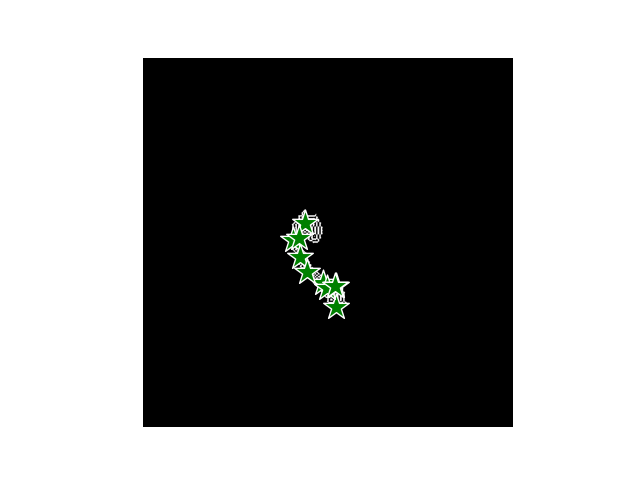

In [17]:
plt.figure()
plt.gca().cla()
plt.imshow(mask_resized, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [18]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [12]:
masks.shape

(1, 1024, 1024)

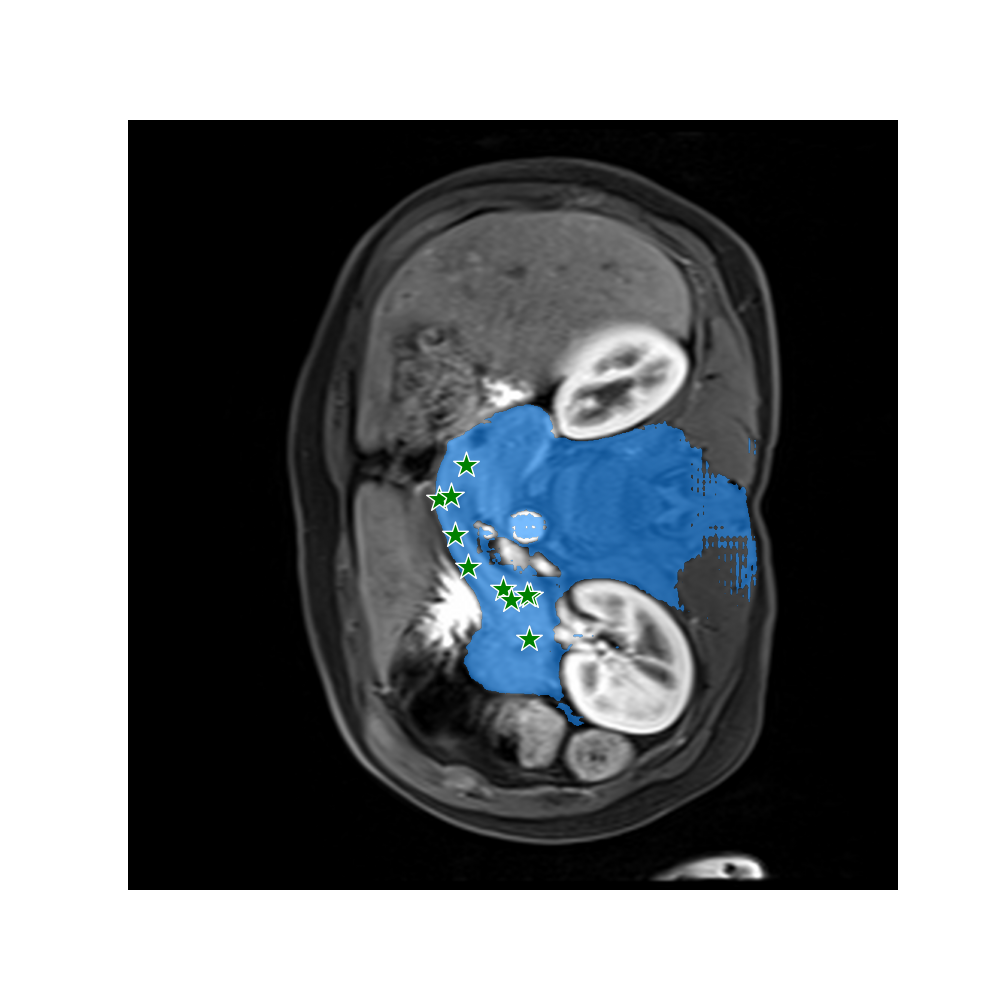

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(img_1024)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### MedSAM: multiple points

In [ ]:


x = random_mask_points[:,1]
y = random_mask_points[:,0]

point_prompt_demo.set_image(img_1024, img_1024_tensor)
point_prompt_demo.infer(x,y)